In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [2]:
file_path = '/content/drive/MyDrive/Omdena/Osun Nigeria/Data/Maize Dataset/data'

In [5]:
name_class = os.listdir(file_path)
name_class

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [7]:
len(filepaths)

4188

In [8]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Omdena/Osun Nigeria/Dat...,Blight
1,/content/drive/MyDrive/Omdena/Osun Nigeria/Dat...,Common_Rust
2,/content/drive/MyDrive/Omdena/Osun Nigeria/Dat...,Healthy
3,/content/drive/MyDrive/Omdena/Osun Nigeria/Dat...,Healthy
4,/content/drive/MyDrive/Omdena/Osun Nigeria/Dat...,Common_Rust


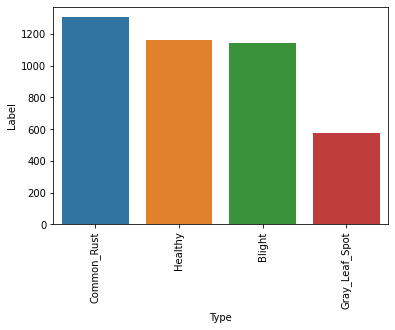

In [9]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.Label)

In [16]:
training, validation = train_test_split(train, test_size = 0.1, random_state=42, stratify=train.Label)

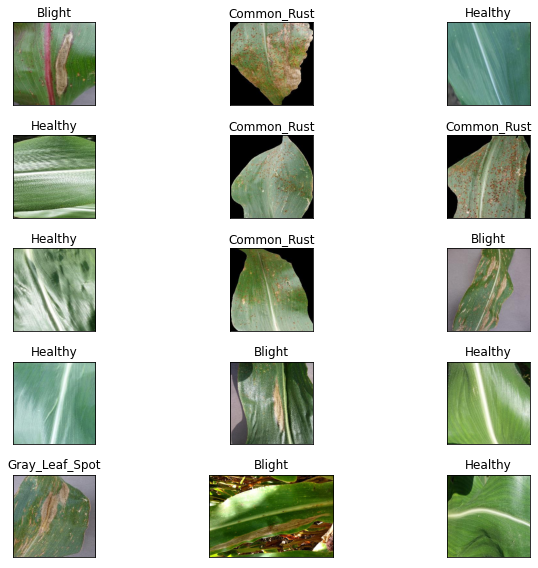

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [18]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=25,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.2, 0.8])
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [19]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=training,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=validation,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3015 validated image filenames belonging to 4 classes.
Found 335 validated image filenames belonging to 4 classes.
Found 838 validated image filenames belonging to 4 classes.


In [20]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [27]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20
95/95 [==============================] - 338s 4s/step - loss: 0.3228 - accuracy: 0.8703 - val_loss: 0.2221 - val_accuracy: 0.9045
Epoch 2/20
95/95 [==============================] - 143s 2s/step - loss: 0.2949 - accuracy: 0.8736 - val_loss: 0.2927 - val_accuracy: 0.8836
Epoch 3/20
95/95 [==============================] - 143s 2s/step - loss: 0.2533 - accuracy: 0.8968 - val_loss: 0.3355 - val_accuracy: 0.8806
Epoch 4/20
95/95 [==============================] - 143s 2s/step - loss: 0.2572 - accuracy: 0.8959 - val_loss: 0.2403 - val_accuracy: 0.9075
Epoch 5/20
95/95 [==============================] - 143s 2s/step - loss: 0.2433 - accuracy: 0.8968 - val_loss: 0.1894 - val_accuracy: 0.9224
Epoch 6/20
95/95 [==============================] - 145s 2s/step - loss: 0.2230 - accuracy: 0.9085 - val_loss: 0.2865 - val_accuracy: 0.8806
Epoch 7/20
95/95 [==============================] - 145s 2s/step - loss: 0.2041 - accuracy: 0.9151 - val_loss: 0.2128 - val_accuracy: 0.9224
Epoch 8/20
95

In [28]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):

  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure()
  plt.plot(train_acc)
  plt.plot(val_acc)
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')
 

  plt.figure()
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train Loss', 'Validation Loss'], loc = 'upper right')
  plt.show()

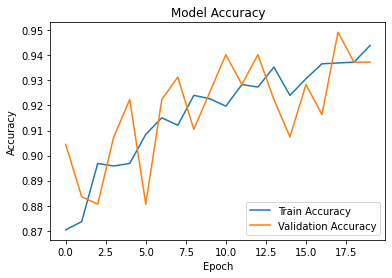

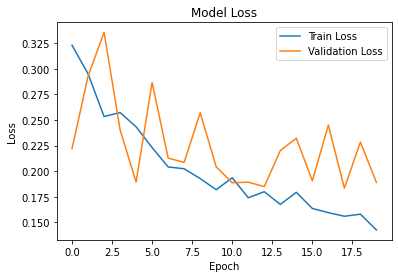

In [29]:
plot_acc_loss(history)

In [32]:
history.model.save('/content/drive/MyDrive/Omdena/Osun Nigeria/Model/model_maize_20eh.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [30]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.25450
Test Accuracy: 91.65%


In [33]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [34]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

        Blight       0.87      0.86      0.87       229
   Common_Rust       0.97      0.96      0.97       261
Gray_Leaf_Spot       0.74      0.78      0.76       115
       Healthy       1.00      0.99      0.99       233

      accuracy                           0.92       838
     macro avg       0.89      0.90      0.90       838
  weighted avg       0.92      0.92      0.92       838



In [35]:
from sklearn.metrics import confusion_matrix

result = confusion_matrix(y_test, pred)
print(result)

[[197   8  23   1]
 [  3 251   7   0]
 [ 25   0  90   0]
 [  1   0   2 230]]


In [36]:
test_label_name = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

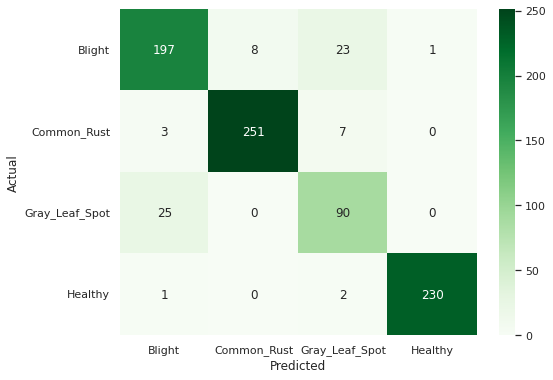

In [37]:
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result, columns=test_label_name, index = test_label_name)
result_df.index.name = 'Actual'
result_df.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1)
sns.heatmap(result_df, cmap='Greens', annot=True, annot_kws={"size": 12}, fmt='d')